In [1]:
import numpy as np
import pandas as pd
import matplotlib as mql
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from numpy.random import standard_normal as stn
from datetime import datetime
from sklearn import linear_model
import statsmodels.api as sm
import scipy.stats as scs
from scipy.stats import norm
import math
from cvxopt import matrix, solvers
import scipy.optimize as sco
from scipy.fftpack import fft,ifft
from sympy import *
from sklearn.decomposition import PCA
import json
from cvxopt import matrix, solvers

E:\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
import pandas as pd
print(pd.__version__)

1.0.3


In [3]:
delta=1.25
P=np.array([-0.1,0,0,-0.2,0.4,-0.1,0.3,0,-0.4,0.1])
mm=1
r0=1/24
r1=0.02*r0
rr=[r1]
q=np.array([-1])

In [4]:
P

array([-0.1,  0. ,  0. , -0.2,  0.4, -0.1,  0.3,  0. , -0.4,  0.1])

Data

In [5]:
icode=['AAPL','BA','TSLA','BABA','GS','GOOG','AMZN','TM','F','JPM']
data=pdr.get_data_yahoo(icode,start='2017-01-01',end='2019-01-01')   # For data
data_close=data['Adj Close']

icode2=['^IRX']
risk_free=pdr.get_data_yahoo(icode2,start='2017-01-01',end='2019-01-01')
risk_free=risk_free['Adj Close']

data_close.head()
returns = np.log(data_close.shift(-1)/data_close)
returns=returns.dropna(axis=0,how='all')     #kill nan
Cov=returns.cov()*252
annual_returns=returns*252
mu=np.mean(annual_returns)
risk_free=risk_free/100
rf=risk_free.mean()[0]

#### $x_{mkt}$

In [6]:
mkt=pdr.get_quote_yahoo(icode)['marketCap']
mkt=mkt/(np.sum(mkt))
mkt_return=np.dot(returns,mkt)
L=mkt_return.std()*np.sqrt(252)

#### $x_{bl}$

In [7]:
P=np.array([-0.1,0,0,-0.2,0.4,-0.1,0.3,0,-0.4,0.1])
num=len(icode)
e=np.zeros(num)+1
r_hat=rf*e+2*delta*np.dot(Cov,mkt)



A1=Cov*r0
A2=np.zeros((num,mm))
A3=np.zeros((mm,num))
A4=np.diag(rr)

Omega1=np.concatenate((A1,A2),axis=1)
Omega2=np.concatenate((A3,A4),axis=1)
Omega=np.concatenate((Omega1,Omega2),axis=0)

B1=np.eye(num,num)
P=P.reshape(1,num)
B=np.concatenate((B1,P),axis=0)

Cov1=Cov
Cov2=np.dot(np.dot(B.T,np.linalg.inv(Omega)),B)
Cov_BL=Cov1+Cov2

C3=np.concatenate((r_hat,q),axis=0)
C1=np.dot(np.linalg.inv(Cov2),B.T)
C2=np.dot(np.linalg.inv(Omega),C3)
mu_BL=np.dot(C1,C2)

num=len(icode)
e=np.zeros(num)+1

def statistics2(weights):
    
    weights=np.array(weights)
    
    Mark1=np.dot(mu_BL.T,weights)
    Mark2=(1-np.dot(e.T,weights))*rf

    
    
    return [Mark1+Mark2]

def max_Mark1(weights):
    
    return -1*statistics2(weights)[0]

cons = (
       {'type':'ineq', 'fun':lambda x: -np.sqrt(np.dot(np.dot(x.T,Cov_BL),x))+L}
       )
bnds = tuple((0,20) for x in range(num))
bl = sco.minimize(max_Mark1, num*[1./num,], method = 'SLSQP',  constraints = cons)
print(bl)
x_bl=bl.x/np.sum(bl.x)*100

     fun: -0.018990460326145615
     jac: array([ 0.01370596,  0.10075245, -0.09492975, -0.30301301,  0.31420483,
        0.01559894,  0.25276179, -0.02000621, -0.39138404,  0.17109764])
 message: 'Optimization terminated successfully.'
    nfev: 411
     nit: 32
    njev: 32
  status: 0
 success: True
       x: array([-0.00193052, -0.0027887 ,  0.0065353 ,  0.00331359, -0.00275684,
       -0.00139502, -0.00238371, -0.00053544,  0.00260381, -0.0020984 ])


#### $x_{mvio}$

In [8]:
##### general case with sigma as vriable.
C_new=2*delta*Cov
alpha=0.87
ee=10**(-8)
value,vector=np.linalg.eig(C_new)


import cvxpy as cvx
mu_io = cvx.Variable((10,1))
sigma_bar = cvx.Variable((10,10))
t = cvx.Variable((1,1))
u = cvx.Variable((11,1))
rf = rf
Omega = Omega 
x_mkt = np.array(mkt).reshape(-1,1)
e = e.reshape(-1,1)
I = np.identity(11)
q = q.reshape(-1,1)

# sigma_bar.dot(x_mkt)
Cons = [
    u - np.linalg.inv(np.sqrt(Omega)) @ cvx.vstack([mu_io - rf*e - sigma_bar@x_mkt, \
                                                          P @ mu_io - q]) == 0,
    cvx.vstack([ cvx.hstack([t, u.T]), cvx.hstack([u, I])]) >> 0,
    value[0:3].sum()>=alpha*cvx.trace(sigma_bar),
    cvx.norm(sigma_bar@vector[:,0]-value[0]*vector[:,0],p=2)<=ee,
    cvx.norm(sigma_bar@vector[:,1]-value[1]*vector[:,1],p=2)<=ee,
    cvx.norm(sigma_bar@vector[:,2]-value[2]*vector[:,2],p=2)<=ee,
    sigma_bar >= 0
]

objective = cvx.Minimize(t)
prob = cvx.Problem(objective, Cons)
prob.solve(solver='CVXOPT')  # Returns the optimal value.
print("status:", prob.status)
print("optimal value", prob.value)
# print("optimal var", x.value, y.value)


num=len(icode)
e=np.zeros(num)+1

def statistics2(weights):
    
    weights=np.array(weights)
    
    Mark1=np.dot(mu_io.value.T,weights)
    Mark2=(1-np.dot(e.T,weights))*rf

    
    
    return [Mark1+Mark2]

def max_Mark1(weights):
    
    return -1/100*statistics2(weights)[0]

cons = (
       {'type':'ineq', 'fun':lambda x: -np.dot(np.dot(x.T,sigma_bar.value/2.5),x)+L**2}
       )
bnds = tuple((0,1) for x in range(num))
mvio = sco.minimize(max_Mark1, num*[1./num,], method = 'SLSQP',  constraints = cons)
print(mvio)
x_mvio=mvio.x/np.sum(mvio.x)*100

status: optimal
optimal value 788.410546189143
     fun: -6602245.146787043
     jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 240
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([ 1.11675270e+08,  1.18785032e+08,  5.89310222e+07,  6.71577366e+07,
       -3.05714706e+08, -1.93478581e+08, -3.22040531e+08, -1.76934740e+08,
       -7.03428224e+07, -2.67409023e+08])


In [9]:
mkt

AAPL    0.268531
BA      0.016321
TSLA    0.031243
BABA    0.121390
GS      0.014167
GOOG    0.186748
AMZN    0.254146
TM      0.038786
F       0.004713
JPM     0.063955
Name: marketCap, dtype: float64

In [10]:
x_mkt

array([[0.26853077],
       [0.01632061],
       [0.03124263],
       [0.12138998],
       [0.01416715],
       [0.18674846],
       [0.25414631],
       [0.03878609],
       [0.00471327],
       [0.06395473]])

,mean,std,SR
mkt,0.201940,0.205281,0.983721
BL,0.354702,2.294016,0.154621
MVIO,0.005800,0.189096,0.030674


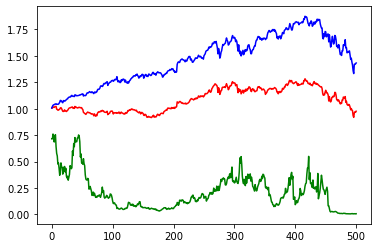

In [11]:
mvio_return=np.dot(returns,x_mvio/100)
mkt_return=np.dot(returns,x_mkt)
bl_return=np.dot(returns,x_bl/100)
plt.plot(np.cumprod(1+mvio_return), color='red')
plt.plot(np.cumprod(1+mkt_return), color='blue')
plt.plot(np.cumprod(1+bl_return), color='green')

result = pd.DataFrame([[0,0,0] for i in range(3)], columns = ['mean','std','SR'], index=['mkt','BL','MVIO'])

result.iloc[2,0]=mvio_return.mean()*252
result.iloc[2,1]=mvio_return.std()*np.sqrt(252)
result.iloc[2,2]=mvio_return.mean()/mvio_return.std()*np.sqrt(252)

result.iloc[0,0]=mkt_return.mean()*252
result.iloc[0,1]=mkt_return.std()*np.sqrt(252)
result.iloc[0,2]=mkt_return.mean()/mkt_return.std()*np.sqrt(252)

result.iloc[1,0]=bl_return.mean()*252
result.iloc[1,1]=bl_return.std()*np.sqrt(252)
result.iloc[1,2]=bl_return.mean()/bl_return.std()*np.sqrt(252)

result

In [12]:
bl_return.std()*np.sqrt(252)

2.2940159055928047

array([ 6.13086417e-03,  6.22212813e-03,  1.79980072e-02,  1.31584621e-02,
        1.21568803e-02,  1.85845420e-02,  2.03112847e-02,  2.20423387e-02,
       -4.60262291e-03, -6.62941257e-03, -1.37869248e-02, -1.28728571e-02,
       -7.48680449e-03, -4.59443054e-03,  7.34308121e-03,  1.03571634e-02,
        2.58664629e-03, -1.00707936e-02, -2.40504494e-02, -2.56227198e-02,
       -2.34182342e-02, -1.00326812e-02, -2.08568497e-02, -2.24124930e-02,
       -2.58469591e-02, -2.08060199e-02, -1.47077630e-02, -4.69172413e-03,
        4.06635835e-03,  8.47952698e-03,  9.72804725e-03,  9.90077126e-03,
        1.57738054e-02,  1.46602431e-02,  1.72802627e-02,  3.84722471e-03,
        1.05082648e-02,  3.94297223e-03,  2.24654739e-02,  1.28543895e-02,
        1.64665748e-02,  1.17183766e-02,  8.35479951e-03,  9.16228787e-03,
        1.38812987e-02,  1.36374794e-02,  1.41236699e-02,  9.37460166e-03,
        1.15110932e-02,  1.13109601e-02, -1.36882713e-04, -6.84839303e-03,
       -3.31840887e-02, -

array([  1.00613086,   2.00622213,   3.01799801,   4.01315846,
         5.01215688,   6.01858454,   7.02031128,   8.02204234,
         8.99539738,   9.99337059,  10.98621308,  11.98712714,
        12.9925132 ,  13.99540557,  15.00734308,  16.01035716,
        17.00258665,  17.98992921,  18.97594955,  19.97437728,
        20.97658177,  21.98996732,  22.97914315,  23.97758751,
        24.97415304,  25.97919398,  26.98529224,  27.99530828,
        29.00406636,  30.00847953,  31.00972805,  32.00990077,
        33.01577381,  34.01466024,  35.01728026,  36.00384722,
        37.01050826,  38.00394297,  39.02246547,  40.01285439,
        41.01646657,  42.01171838,  43.0083548 ,  44.00916229,
        45.0138813 ,  46.01363748,  47.01412367,  48.0093746 ,
        49.01151109,  50.01131096,  50.99986312,  51.99315161,
        52.96681591,  53.96207249,  54.95735911,  55.95134058,
        56.94645017,  57.95750606,  58.96312466,  59.9699055 ,
        60.96646079,  61.96271308,  62.96448323,  63.96